#  Predicting passenger survival with MCMC

This notebook intends to show the application of probabilisitic programming to the Titanic dataset from Kaggle. We start with the usual loading of libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pymc3 as pm
import seaborn

import theano.tensor as T
import theano
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

%matplotlib inline

## I. Preparatory steps: Reading and cleaning

In [2]:
path_ = "/Users/rcuevas/Documents/Personal/ProLO-MeetUp/data/"

In [3]:
dfTrain = pd.read_csv(path_+'train.csv')

Check what the data look like:

In [4]:
dfTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's see shape of dataframe, features of dataset as well as number of NaN's for each column

In [5]:
dfTrain.shape

(891, 12)

In [6]:
dfTrain.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [7]:
dfTrain.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [8]:
dfTrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We have ~20% of NaN. Let's replace the NaN with a negative value, say -1.

In [9]:
dfTrain['Age'] = dfTrain['Age'].fillna(-1) 

In [10]:
dfTrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## II. Visualization

Let's select some columns of interest and get correaltion matrix as well as pairplot. For this we first turn some numeric variables into categorical by turning them into strings:

In [11]:
dfTrain.SiSp = dfTrain.SibSp.astype(str)
dfTrain.Parch = dfTrain.Parch.astype(str)
dfTrain.Pclass = dfTrain.Pclass.astype(str)

and then we grab the columns of interest to make the mentioned plot

In [12]:
dfTrain[['Survived','Pclass','Sex','Age','Fare']].head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [13]:
dfTrain_Aux = pd.get_dummies(dfTrain[['Survived','Pclass','Sex','Age','Fare']])

In [14]:
dfTrain_Aux.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,7.2500,0.0,0.0,1.0,0.0,1.0
1,1,38.0,71.2833,1.0,0.0,0.0,1.0,0.0
2,1,26.0,7.9250,0.0,0.0,1.0,1.0,0.0
3,1,35.0,53.1000,1.0,0.0,0.0,1.0,0.0
4,0,35.0,8.0500,0.0,0.0,1.0,0.0,1.0


Is there any *visible* correlation or recognizable distribution? 

In [15]:
#pairPlotTrain = seaborn.pairplot(dfTrain_Aux)

We now compute the correlation matrix to plot a heatmap

In [15]:
corrTrain = dfTrain_Aux.corr()

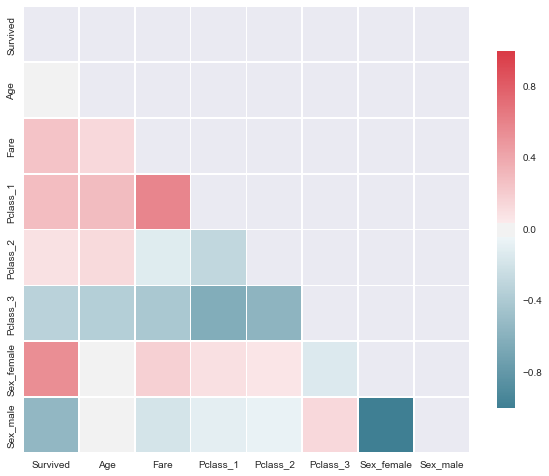

In [16]:
# We consider mask for upper triangle
mask = np.zeros_like(corrTrain, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw heatmap with mask and correct aspect ratio
seaborn.heatmap(corrTrain, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.8, cbar_kws={"shrink": .8}, ax=ax)

It seems our data are highly correlated

## III. Probabilistic Programming Models

#### III.A. Bayesian Neural Network

Let's try a Bayesian Neural Network with one hidden layer. 

![](data/ANN_OneLayer.jpg)

We choose the features listed before and extract target.

In [17]:
list_features = ['Pclass','Sex','Age','Fare','SibSp','Parch']

We convert categorical variable into dummy/indicator variables with *get_dummies*

In [18]:
XTrain = pd.get_dummies(dfTrain[list_features]).values
yTrain = dfTrain.Survived.values

We try a typical split into test and training sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(XTrain, yTrain, train_size=0.7,random_state=2016)

In [20]:
print X_train.shape
print X_test.shape

(623, 15)
(268, 15)


Mean and std for chosen feature of training set

In [21]:
mean_array = np.mean(X_train,axis=0)
std_array = np.std(X_train,axis=0)
print "==================================="
print "Mean array"
print mean_array
print "==================================="
print "Std array"
print std_array

Mean array
[  2.33717175e+01   3.16978921e+01   5.71428571e-01   2.47191011e-01
   1.97431782e-01   5.55377207e-01   3.45104334e-01   6.54895666e-01
   7.60834671e-01   1.33226324e-01   8.82825040e-02   8.02568218e-03
   1.60513644e-03   6.42054575e-03   1.60513644e-03]
Std array
[  1.75997976e+01   4.47758640e+01   1.21161542e+00   4.31378738e-01
   3.98060891e-01   4.96923903e-01   4.75402285e-01   4.75402285e-01
   4.26573879e-01   3.39819174e-01   2.83705311e-01   8.92259526e-02
   4.00319869e-02   7.98706601e-02   4.00319869e-02]


We scale training set...

In [22]:
XTrainScaled = scale(X_train)
#XTrainScale = X_train

In [23]:
XTrainScaled

array([[-0.07793939, -0.53428097, -0.47162537, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 0.03569828, -0.35393828,  0.35371903, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [-0.87340308, -0.05746159,  2.82975223, ..., -0.04009635,
        -0.08038679, -0.04009635],
       ..., 
       [-0.4188524 ,  0.17843559,  2.82975223, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [-0.30521473, -0.38511132, -0.47162537, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [-0.47567124, -0.54656438, -0.47162537, ..., -0.04009635,
        -0.08038679, -0.04009635]])

We add a bias (intercept) for our model

In [24]:
XTrainScaled_Bias = np.ones((XTrainScaled.shape[0],XTrainScaled.shape[1]+1))
XTrainScaled_Bias[:,1:] = XTrainScaled

In [25]:
XTrainScaled_Bias

array([[ 1.        , -0.07793939, -0.53428097, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        ,  0.03569828, -0.35393828, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        , -0.87340308, -0.05746159, ..., -0.04009635,
        -0.08038679, -0.04009635],
       ..., 
       [ 1.        , -0.4188524 ,  0.17843559, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        , -0.30521473, -0.38511132, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        , -0.47567124, -0.54656438, ..., -0.04009635,
        -0.08038679, -0.04009635]])

Turn inputs and outputs into shared variables so that we can change them later

In [26]:
ann_input = theano.shared(XTrainScaled_Bias)
ann_output = theano.shared(y_train)
n_Neuron = 5 # number of units for hidden neural network

In [27]:
# Initialize random weights.
init_1 = np.random.randn(XTrainScaled_Bias.shape[1], n_Neuron)
# The following line is in case we wish to add a second hidden layer
#init_2 = np.random.randn(n_Neuron, n_Neuron)
init_out = np.random.randn(n_Neuron)

with pm.Model() as neural_network_01:
    # Weights from input to hidden layer with Normal distribution
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(XTrainScaled_Bias.shape[1], n_Neuron), 
                             testval=init_1)
    
    # The following lines of code  are to add weights from first hidden layer to second hidden layer
    # in case we wish to add so
    #weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
    #                        shape=(n_Neuron, n_Neuron), 
    #                        testval=init_2)
    
    # Weights from hidden layer to output with Normal distribution
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_Neuron,), 
                              testval=init_out)
    
    # Let's build neural-network with tanh activation functions...
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    # Once again, the following line is in case we wish to add a second hidden layer
    #act_2 = T.tanh(T.dot(act_1, weights_1_2))
    
    # We could also try sigmoid activation function but let's try that later
    #act_1 = T.nnet.sigmoid(T.dot(ann_input, weights_in_1))
    #act_2 = T.nnet.sigmoid(T.dot(act_1, weights_1_2))
    
    
    act_out = T.nnet.sigmoid(T.dot(act_1, weights_2_out))
    
    
    # Set output with a Bernoulli distribution
    out = pm.Bernoulli('out', act_out,observed=ann_output)

Run model itself

In [30]:
with neural_network_01:    
    step = pm.Metropolis()
    
    #step = pm.NUTS()
    start = pm.find_MAP()
    
    #trace_ANN_01 = pm.sample(2000000, step=step)#[10000:]
    trace_ANN_01 = pm.sample(500000, step=step, start=start,  progressbar=True)

 [-----------------100%-----------------] 500000 of 500000 complete in 356.7 sec

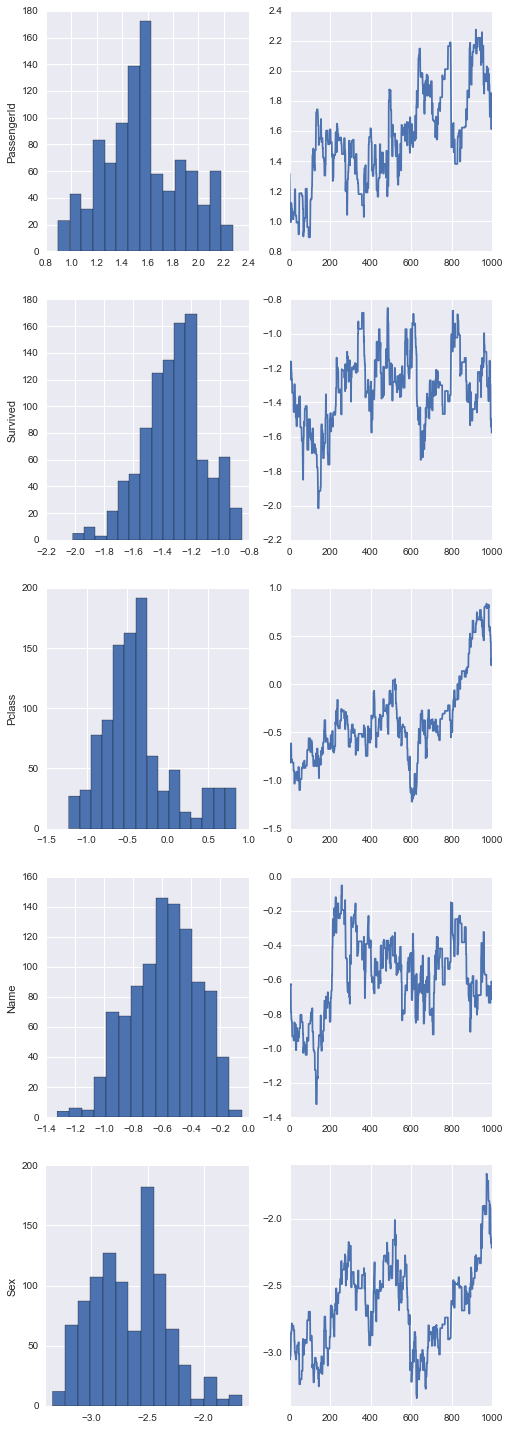

In [31]:
params_ANN_01 = trace_ANN_01["w_2_out"][-1000:]
plt.figure(figsize=(8,25))
nb_plots = params_ANN_01.shape[1]
bins=15
for i in range(nb_plots):
    plt.subplot(nb_plots, 2, i*2+2) 
    plt.plot(range(params_ANN_01.shape[0]), params_ANN_01[:,i])
    plt.subplot(nb_plots, 2, i*2+1)
    plt.hist(params_ANN_01[:,i], bins=bins)
    plt.ylabel(dfTrain.columns[i])

Let's normalize the test set

In [32]:
X_test_Norm = np.zeros(X_test.shape)
for k in range(X_test_Norm.shape[1]):
    if ((mean_array[k] != 0) & (std_array[k] !=0)):
        X_test_Norm[:,k] =  (X_test[:,k] - mean_array[k])/std_array[k]

In [33]:
np.mean(X_test_Norm,axis = 0)

array([ 0.04324374,  0.03759417, -0.13286461, -0.03673739,  0.07581794,
       -0.02884231,  0.05111177, -0.05111177,  0.00084243, -0.00773738,
        0.01762772, -0.08994785,  0.23953079, -0.03366947, -0.04009635])

In [34]:
np.std(X_test_Norm,axis = 0)

array([  1.04725988e+00,   1.32844998e+00,   6.43372788e-01,
         9.77543125e-01,   1.05333323e+00,   1.00279434e+00,
         1.01523105e+00,   1.01523105e+00,   9.99484396e-01,
         9.91583541e-01,   1.02511097e+00,   3.33066907e-16,
         2.62809842e+00,   7.63367319e-01,   1.04083409e-16])

We add bias for test set

In [35]:
# Intercept for test set
XTestScaled_Bias = np.ones((X_test_Norm.shape[0],X_test_Norm.shape[1]+1))
XTestScaled_Bias[:,1:] = X_test_Norm

In [36]:
XTestScaled_Bias

array([[ 1.        ,  0.77434314, -0.49380157, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        , -0.36203357, -0.38501975, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        ,  0.37661129, -0.49575575, ..., -0.04009635,
        -0.08038679, -0.04009635],
       ..., 
       [ 1.        ,  0.09251712, -0.53093095, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        ,  0.83116197,  0.88407915, ..., -0.04009635,
        -0.08038679, -0.04009635],
       [ 1.        ,  0.14933595, -0.34835491, ..., -0.04009635,
        -0.08038679, -0.04009635]])

In [37]:
# Replace shared variables with testing set
ann_input.set_value(XTestScaled_Bias)

In [38]:
# Create posterior predictive samples
ppc = pm.sample_ppc(trace_ANN_01, model=neural_network_01, samples=500)
# We set threshold to be 0.5
pred = ppc['out'].mean(axis=0) > 0.5
pred = 1*pred

Let's see some meassures of accuracy. We do the usual mean of absolute value of differences but we also compute ROC-AUC

In [39]:
print('Accuracy = {}%'.format((y_test == pred).mean() * 100))
print('ROC-AUC = {}'.format(roc_auc_score(y_test,pred)))

Accuracy = 80.223880597%
ROC-AUC = 0.777130852341


#### II.B. Predictions for Kaggle

In [40]:
dfTest = pd.read_csv(path_+'test.csv')
dfTrain = pd.read_csv(path_+'train.csv')

In [41]:
list_features

['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']

In [42]:
dfTrain['Age'] = dfTrain['Age'].fillna(-2)
dfTest['Age'] = dfTest['Age'].fillna(-2)
dfTest['Fare'] = dfTest['Fare'].fillna(-2)

In [43]:
yTrain = dfTrain.Survived.values

In [44]:
dfTest.SiSp = dfTest.SibSp.astype(str)
dfTest.Parch = dfTest.Parch.astype(str)
dfTest.Pclass = dfTest.Pclass.astype(str)

dfTrain.SiSp = dfTrain.SibSp.astype(str)
dfTrain.Parch = dfTrain.Parch.astype(str)
dfTrain.Pclass = dfTrain.Pclass.astype(str)

In [45]:
dfTrain = pd.get_dummies(dfTrain[list_features])

In [46]:
dfTest = pd.get_dummies(dfTest[list_features])

In [47]:
dfTest = dfTest[dfTrain.columns.values]

In [48]:
XTrain = dfTrain.values
XTrainScale = scale(XTrain)

In [49]:
mean_array_Train = np.mean(XTrain,axis=0)
std_array_Train = np.std(XTrain,axis=0)

In [50]:
XTest = dfTest.values
XTestScale = np.zeros(XTest.shape)
#XTestScale = XTest
for k in range(XTest.shape[1]):
    XTestScale[:,k] = (XTest[:,k] - mean_array_Train[k])/std_array_Train[k]

In [51]:
# Intercept for test set
XTrainScale_Bias = np.ones((XTrainScale.shape[0],XTrainScale.shape[1]+1))
XTrainScale_Bias[:,1:] = XTrainScale

In [52]:
# Turn inputs and outputs into shared variables so that we can change them later
ann_input = theano.shared(XTrainScale_Bias)
ann_output = theano.shared(yTrain)
n_Neuron = 5

# Initialize random weights.
init_1 = np.random.randn(XTrainScale_Bias.shape[1], n_Neuron)
#init_2 = np.random.randn(n_Neuron, n_Neuron)
init_out = np.random.randn(n_Neuron)

with pm.Model() as neural_network_2:
    # Weights from input to first layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(XTrainScale_Bias.shape[1], n_Neuron), 
                             testval=init_1)
    
    # Weights from first to second layer
    #weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
    #                        shape=(n_Neuron, n_Neuron), 
    #                        testval=init_2)
    
    # Weights from second layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_Neuron,), 
                              testval=init_out)
    
    # Build neural-network
    # Same as before, we choose tanh as activation functions...
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    #act_2 = T.tanh(T.dot(act_1, weights_1_2))
    #act_1 = T.nnet.sigmoid(T.dot(ann_input, weights_in_1))
    #act_2 = T.nnet.sigmoid(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_1, weights_2_out))
    
    out = pm.Bernoulli('out',act_out,observed=ann_output)

In [53]:
with neural_network_2:
    step = pm.Metropolis()
    trace_ANN_02 = pm.sample(50000, step=step)[10000:]

 [-----------------100%-----------------] 50000 of 50000 complete in 42.7 sec

Let's plot some of the parameters

In [54]:
# Intercept for test set
XTestScale_Bias = np.ones((XTestScale.shape[0],XTestScale.shape[1]+1))
XTestScale_Bias[:,1:] = XTestScale

In [55]:
# Replace shared variables with testing set
ann_input.set_value(XTestScale_Bias)

In [56]:
# Create posterior predictive samples
ppc = pm.sample_ppc(trace_ANN_02, model=neural_network_2, samples=500)

pred = ppc['out'].mean(axis=0) > 0.5
pred = 1*pred

In [57]:
dfTest['PassengerId']  = pd.read_csv(path_+'test.csv').PassengerId

In [58]:
dfTest.head()

,Age,Fare,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,PassengerId
0,34.5,7.8292,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,892
1,47.0,7.0000,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,893
2,62.0,9.6875,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,894
3,27.0,8.6625,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,895
4,22.0,12.2875,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,896


In [59]:
predictions_out = pd.Series(pred, index=dfTest.PassengerId, name="Survived")
predictions_out.to_csv(path_+"predictions_ann_tanh_scaled_bias.csv", header=True)
!head logistic_predictions.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


This subission in Kaggle scored 0.78669
Your submission scored 0.78469 (with bias unit)

#### II.C. Variational inference with ADVI

In [64]:
# Restore to original data
ann_input.set_value(XTrainScale_Bias)
ann_output.set_value(yTrain)

Let's try to run ADVI (automatic differntiation variational inference) and get ELBO (evidence lower bound)

In [65]:
with neural_network_2:
    means, sds, elbos = pm.variational.advi(n=20000, accurate_elbo=True)

Iteration 0 [0%]: ELBO = -1006.95
Iteration 2000 [10%]: Average ELBO = -706.9
Iteration 4000 [20%]: Average ELBO = -498.58
Iteration 6000 [30%]: Average ELBO = -452.17
Iteration 8000 [40%]: Average ELBO = -437.83
Iteration 10000 [50%]: Average ELBO = -433.9
Iteration 12000 [60%]: Average ELBO = -433.45
Iteration 14000 [70%]: Average ELBO = -433.38
Iteration 16000 [80%]: Average ELBO = -433.36
Iteration 18000 [90%]: Average ELBO = -433.4
Finished [100%]: Average ELBO = -433.42


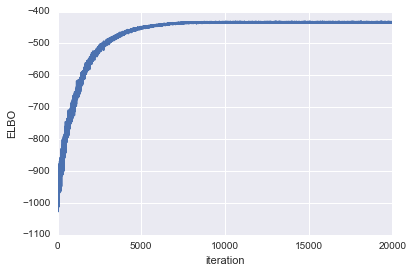

In [66]:
plt.plot(elbos)
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [ ]:
# The following cells are to explore this problem further....

In [ ]:
params_ANN_01 = trace_ANN_01["w_2_out"]
plt.figure(figsize=(8,25))
nb_plots = params_ANN_01.shape[1]
bins=15
for i in range(nb_plots):
    plt.subplot(nb_plots, 2, i*2+2) 
    plt.plot(range(params_ANN_01.shape[0]), params_ANN_01[:,i])
    plt.subplot(nb_plots, 2, i*2+1)
    plt.hist(params_ANN_01[:,i], bins=bins)
    plt.ylabel(dfTrain.columns[i])

In [ ]:
params_ANN_02 = trace_ANN_02["w_2_out"]
plt.figure(figsize=(8,25))
nb_plots = params_ANN_02.shape[1]
bins=15
for i in range(nb_plots):
    plt.subplot(nb_plots, 2, i*2+2) 
    plt.plot(range(params_ANN_02.shape[0]), params_ANN_02[:,i])
    plt.subplot(nb_plots, 2, i*2+1)
    plt.hist(params_ANN_02[:,i], bins=bins)
    plt.ylabel(dfTrain.columns[i])